In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mosaic24-ps1/sample_submission.csv
/kaggle/input/mosaic24-ps1/train.csv
/kaggle/input/mosaic24-ps1/test.csv


In [2]:

import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

2024-03-13 17:24:10.970460: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 17:24:10.970584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 17:24:11.256822: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train = pd.read_csv("/kaggle/input/mosaic24-ps1/train.csv")
test = pd.read_csv("/kaggle/input/mosaic24-ps1/test.csv")

In [4]:
train

,Id,Date,Open,High,Low,Close,Adj Close,Volume,Company
0,0,2033-03-01,159.271109,167.221488,157.380478,161.915062,160.167043,40490589,Company_0
1,1,2033-03-01,114.571843,114.409664,112.921505,113.066659,87.844722,8592865,Company_1
2,2,2033-03-01,50.984499,51.262529,50.266272,50.094499,49.329834,25085661,Company_2
3,3,2033-03-01,98.585428,99.988079,97.867719,98.811966,91.784469,823271,Company_3
4,4,2033-03-01,8874.646107,8935.704765,8811.247764,8873.173069,8407.389386,609369,Company_4
...,...,...,...,...,...,...,...,...,...
7411,7411,2038-02-28,104.074758,104.325097,102.299154,102.070115,95.938421,17617907,Company_1
7412,7412,2038-02-28,6.825210,7.378966,6.536319,6.484569,6.664250,67725048,Company_2
7413,7413,2038-02-28,96.702497,102.527327,96.123058,101.977618,100.731773,5257824,Company_3
7414,7414,2038-02-28,8650.533559,8709.103373,8604.908934,8623.897896,8543.781858,370998,Company_4


In [5]:
test

,Id,Date,Company
0,0,2038-03-01,Company_0
1,1,2038-03-01,Company_1
2,2,2038-03-01,Company_2
3,3,2038-03-01,Company_3
4,4,2038-03-01,Company_4
...,...,...,...
571,571,2038-07-21,Company_1
572,572,2038-07-21,Company_2
573,573,2038-07-21,Company_3
574,574,2038-07-21,Company_4


In [6]:
print("Null values:", train.isnull().values.sum())

print("NA values:", train.isna().values.any())

Null values: 0
NA values: False


In [7]:
# Pivot the DataFrame
df_closing = train.pivot(index='Date', columns='Company', values=['Close'])

# Flatten the MultiIndex columns
df_closing.columns = ['_'.join(col).strip() for col in df_closing.columns.values]

# Reset index for better structure
df_closing.reset_index(inplace=True)

# Display the result
df_closing.head()

,Date,Close_Company_0,Close_Company_1,Close_Company_2,Close_Company_3,Close_Company_4,Close_Company_5
0,2033-03-01,161.915062,113.066659,50.094499,98.811966,8873.173069,135.882546
1,2033-03-05,163.108507,110.561246,49.250071,96.594597,8794.758109,135.970813
2,2033-03-06,161.716298,109.651386,48.878616,93.602065,8616.178598,136.070561
3,2033-03-07,148.051907,109.723772,48.670564,90.718080,8679.165970,135.772818
4,2033-03-08,148.483368,109.118052,47.642654,90.771456,8729.613528,137.854360


In [8]:
df_closing_company0 = df_closing[['Date', 'Close_Company_0']]


In [9]:
print("DataFrame for Company 0:")
print(df_closing_company0.head())
print()



DataFrame for Company 0:
         Date  Close_Company_0
0  2033-03-01       161.915062
1  2033-03-05       163.108507
2  2033-03-06       161.716298
3  2033-03-07       148.051907
4  2033-03-08       148.483368



In [10]:
df_closing_company0.loc[:, 'Date'] = pd.to_datetime(df_closing_company0['Date'], utc=True)

In [11]:



from datetime import datetime
import pytz

# Convert the string to a timezone-aware Timestamp object
date_threshold_str = '2033-06-01'
date_threshold = pd.Timestamp(datetime.strptime(date_threshold_str, '%Y-%m-%d'), tz=pytz.UTC)

# Filter the DataFrame based on the condition
stock_df_close_last_1_year = df_closing_company0[df_closing_company0['Date'] > date_threshold]

# Make a copy of the filtered DataFrame
stock_df_close_last_1_year_original_gt = stock_df_close_last_1_year.copy()

# Print the total data for prediction
print("Total data for prediction: ", stock_df_close_last_1_year.shape[0])


Total data for prediction:  1173


In [12]:

import plotly.express as px  # Import Plotly Express library for creating interactive plots

# Create line plot
fig = px.line(df_closing, x=df_closing.Date, y=df_closing.Close_Company_0, labels={'Date':'Date','Close_Company_0':'Close_Company_0'})

# Update traces (lines) properties
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')

# Update layout properties
fig.update_layout(title_text='Considered period to predict Close price', plot_bgcolor='white', font_size=15, font_color='black')

# Update x-axis properties
fig.update_xaxes(showgrid=False)

# Update y-axis properties
fig.update_yaxes(showgrid=False)

# Show the plot
fig.show()



In [13]:

training_size=int(len(stock_df_close_last_1_year)*0.80)

test_size=len(stock_df_close_last_1_year)-training_size

train_data,test_data = stock_df_close_last_1_year[0:training_size], stock_df_close_last_1_year[training_size:len(stock_df_close_last_1_year)]

print("train_data: ", train_data.shape)  # (201, 2)

print("test_data: ", test_data.shape)

train_data:  (938, 2)
test_data:  (235, 2)


In [14]:
del train_data['Date']

del test_data['Date']

In [15]:
scaler=MinMaxScaler(feature_range=(0,1))

train_data=scaler.fit_transform(np.array(train_data).reshape(-1,1))

test_data = scaler.transform(np.array(test_data).reshape(-1,1))

print(train_data.shape)



(938, 1)


In [16]:
def create_sliding_window(dataset, time_step=200):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [17]:
time_step = 200

X_train, y_train = create_sliding_window(train_data, time_step)

X_test, y_test = create_sliding_window(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)


X_train:  (737, 200)
y_train:  (737,)
X_test:  (34, 200)
y_test (34,)


In [18]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (737, 200, 1)
X_test:  (34, 200, 1)


In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, GRU, Dense, Dropout, Bidirectional, TimeDistributed, MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2

model = tf.keras.Sequential()
model.add(Conv1D(12, kernel_size=5, activation='relu', input_shape=(200, 1)))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(2))
# GRU layers
model.add(Bidirectional(GRU(100, return_sequences=False)))
model.add(Dropout(0.5))
# Final layers
model.add(Dense(1, activation='linear'))

# Compilation
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 196, 12)        │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 194, 64)        │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 97, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200)            │        99,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,241 (399.38 KB)

 Trainable params: 102,241 (399.38 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # If CUDA is available, set the device to GPU
    device = torch.device("cuda")
    print("CUDA is available! Using GPU.")
else:
    # If CUDA is not available, set the device to CPU
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

# Example usage:
# Create a tensor and move it to the selected device
x = torch.randn(3, 3).to(device)

# Perform operations on the tensor
y = torch.matmul(x, x.transpose(0, 1))

# Move the tensor back to CPU if needed
y = y.to("cpu")

# You can also specify GPU device number if you have multiple GPUs
# device = torch.device("cuda:0")  # Use GPU 0
# device = torch.device("cuda:1")  # Use GPU 1


CUDA is available! Using GPU.


In [22]:
print(f"Device is {device}.")

Device is cuda.


In [23]:
history = model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=300, batch_size=100, verbose=1)

Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - loss: 0.1265 - mae: 0.2512 - mse: 0.1274 - val_loss: 0.0162 - val_mae: 0.1256 - val_mse: 0.0162
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0338 - mae: 0.1621 - mse: 0.0340 - val_loss: 0.0020 - val_mae: 0.0398 - val_mse: 0.0020
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0125 - mae: 0.0852 - mse: 0.0126 - val_loss: 0.0079 - val_mae: 0.0865 - val_mse: 0.0079
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0066 - mae: 0.0531 - mse: 0.0066 - val_loss: 0.0204 - val_mae: 0.1411 - val_mse: 0.0204
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0065 - mae: 0.0555 - mse: 0.0066 - val_loss: 0.0027 - val_mae: 0.0483 - val_mse: 0.0027
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0051 - mae: 0.0478 - mse: 0.0052 - val_loss: 0.0057 - val_mae: 0.0728 - val_mse: 0.0057
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0049 - mae: 0.0486 - mse: 0.0049 - val_loss: 0.0014

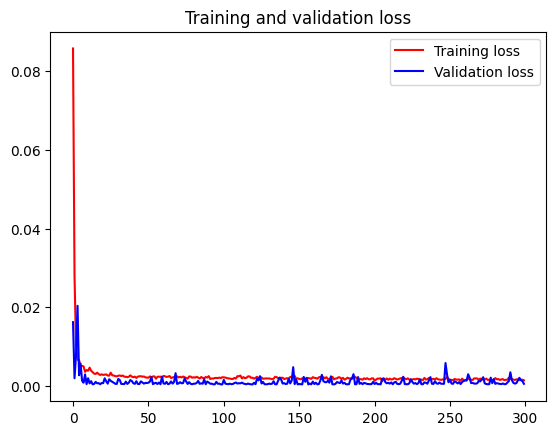

<Figure size 640x480 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')

plt.legend(loc=0)

plt.figure()


plt.show()

In [25]:
train_predict=model.predict(X_train)

test_predict=model.predict(X_test)

train_predict.shape, test_predict.shape

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


((737, 1), (34, 1))

In [26]:
train_predict = scaler.inverse_transform(train_predict)

test_predict = scaler.inverse_transform(test_predict)

original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 

original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [27]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain, train_predict)))

print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))

print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))

print("-------------------------------------------------------------------------------------")

print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))

print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))

print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  4.672255144049549
Train data MSE:  21.829968131097473
Train data MAE:  3.53469218481503
-------------------------------------------------------------------------------------
Test data RMSE:  4.638788531342246
Test data MSE:  21.518359038512347
Test data MAE:  3.7482970042339514


In [28]:
original_ytest.shape

(34, 1)

In [29]:
# Reshape test data to use as input for prediction
x_input = test_data[len(test_data) - time_step:].reshape(1, time_step, -1)
print("x_input.shape ", x_input.shape)
# print("x_input", x_input)
print('###########################################################################')

from numpy import array

# Initialize variables
temp_input = list(x_input)
lst_output = []
n_steps = time_step
pred_days = 96  # Predict for 96 days

for _ in range(pred_days):
    if len(temp_input[0]) > time_step:
        x_input = array(temp_input[0][1:])  # Remove the first element from temp_input
        x_input = x_input.reshape((1, n_steps, -1))
        y_pred = model.predict(x_input, verbose=0)
        
        temp_input[0] = np.append(temp_input[0][1:], y_pred)  # Append the predicted value to temp_input
        lst_output.append(y_pred[0].tolist())
    else:
        # Reshape input for prediction if temp_input length is less than time_step
        x_input = array(temp_input[0])
        x_input = x_input.reshape((1, n_steps, -1))
        y_pred = model.predict(x_input, verbose=0)
        
        temp_input[0] = np.append(temp_input[0], y_pred)  # Append the predicted value to temp_input
        lst_output.append(y_pred[0].tolist())

print("Output of predicted next days: ", len(lst_output))


x_input.shape  (1, 200, 1)
###########################################################################
Output of predicted next days:  96


In [30]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
temp_matrix = np.empty((len(last_days)+pred_days, 1))

temp_matrix[:] = np.nan

In [31]:
last_original_days_value = temp_matrix

next_predicted_days_value = temp_matrix

last_original_days_value[0:time_step] = (np.array((stock_df_close_last_1_year_original_gt.iloc[-time_step:]['Close_Company_0']))).reshape(-1,1).tolist()

# Assign values to next_predicted_days_value
next_predicted_days_value[time_step:] = (scaler.inverse_transform(lst_output)).tolist()[0]

In [32]:

# Convert next_predicted_days_value to a DataFrame
predictions_df = pd.DataFrame(next_predicted_days_value, columns=['Predictions0'])

# Save the DataFrame to a CSV file
predictions_df.to_csv('predictions0.csv', index=False)


In [33]:

# scaler is your MinMaxScaler object
# Inverse transform lst_output 
new_predicted_values = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))

# Convert predicted_values to a 1D array
new_predicted_values = new_predicted_values.flatten()


# Convert next_predicted_days_value to a DataFrame
new_predictions_df = pd.DataFrame(new_predicted_values, columns=['Predictions0'])

# Save the DataFrame to a CSV file
new_predictions_df.to_csv('newpredictions0.csv', index=False)

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the filepath where the model weights will be saved
filepath = "/kaggle/input/mosaic24-ps1/W4.keras"  # Change the extension to .keras

# Create a ModelCheckpoint callback to save the best model during training
checkpoint = ModelCheckpoint(filepath, verbose=1, monitor='loss', save_best_only=True, mode='min')

# Compile all callbacks into a list
callbacks_list = [checkpoint]

# Train the model using the defined callbacks
model.fit(X_train, y_train, epochs=20, callbacks=callbacks_list)



ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=/kaggle/input/mosaic24-ps1/W4.hdf5